In [1]:
# Importing libraries and setting up the environment
import warnings

warnings.filterwarnings("ignore")  # setting ignore as a parameter
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
from mpl_toolkits.basemap import Basemap
from statsmodels.genmod.families import Binomial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import patches
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


image_format = "svg"

In [2]:
#  Import Future Data
def process_npp_data(filepath):
    npp_data = pd.read_csv(
        filepath,
        names=[
            "LON",
            "LAT",
            "VARNAME",
            "ICOHORT",
            "STANDAGE",
            "POTVEG",
            "CURRENTVEG",
            "SUBTYPE",
            "CMNT",
            "PSIPLUSC",
            "QLCON",
            "CAREA",
            "SUBAREA",
            "YEAR",
            "TOTAL_NPP",
            "MAX_NPP",
            "AVE_NPP",
            "MIN_NPP",
            "JAN",
            "FEB",
            "MAR",
            "APR",
            "MAY",
            "JUN",
            "JUL",
            "AUG",
            "SEP",
            "OCT",
            "NOV",
            "DEC",
            "REGION",
        ],
    )
    npp_data = npp_data[
        ["LON", "LAT", "POTVEG", "YEAR", "TOTAL_NPP", "MAX_NPP", "AVE_NPP", "MIN_NPP"]
    ]
    return npp_data


# .csv files share the same root directory
shared_root_path = (
    "/processing/"
)


# .csv files for all models share the same path except for the model name
npp_data_shared_path = "/data/output_bakeoff/npp_bakeoff_result.csv"

# Australia
model_1 = process_npp_data(shared_root_path + "australia" + npp_data_shared_path)
# Canada
model_2 = process_npp_data(shared_root_path + "canada" + npp_data_shared_path)

# China
model_3 = process_npp_data(shared_root_path + "china" + npp_data_shared_path)

# France
model_4 = process_npp_data(shared_root_path + "france" + npp_data_shared_path)
# Japan
model_5 = process_npp_data(shared_root_path + "japan" + npp_data_shared_path)

# Norway
model_6 = process_npp_data(shared_root_path + "norway" + npp_data_shared_path)
# United Kingdom
model_7 = process_npp_data(shared_root_path + "united_kingdom" + npp_data_shared_path)

# United States CCSM4
model_8 = process_npp_data(shared_root_path + "united_states_1" + npp_data_shared_path)

# United States GFDL
model_9 = process_npp_data(shared_root_path + "united_states_2" + npp_data_shared_path)


# Merge all models into a single dataframe
future_npp = pd.concat(
    [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9]
)

In [3]:
# Group by 'year' and 'potveg' and calculate mean for each group
all_models_mean = (
    future_npp.groupby(["LON", "LAT", "POTVEG", "YEAR"]).mean().reset_index()
)
# all_models_mean = all_models_mean.query("YEAR>= 2070 and POTVEG != 99")

# Create new dataframe with a copy of all_models_mean
mean_future_npp = (
    all_models_mean.groupby(["LON", "LAT", "POTVEG", "YEAR"], as_index=False)
    .agg({"TOTAL_NPP": "mean", "MAX_NPP": "mean", "AVE_NPP": "mean", "MIN_NPP": "mean"})
    .round(4)
)
mean_future_npp = mean_future_npp.query("YEAR>= 2070 and POTVEG != 99")

# Import datasets
precipitation = pd.read_csv(
    "../data/prec_west.csv", names=["LON", "LAT", "YEAR", "TOTAL_PREC", "AVE_PREC"]
)
temperature = pd.read_csv(
    "../data/tair_west.csv", names=["LON", "LAT", "YEAR", "TOTAL_AVE", "AVE_TAIR"]
)
moisture_stress = pd.read_csv(
    "../data/beta_west.csv", names=["LON", "LAT", "YEAR", "BETA"]
)
elevation = pd.read_csv("../data/elevation.csv", names=["LON", "LAT", "ELEVATION"])
end_century_landcover = pd.read_csv(
    "../data/agg_models_landcover.csv", names=["LON", "LAT", "POTVEG"]
)
climate_limits = pd.read_csv(
    "../data/bio_limit.csv",
    names=[
        "POTVEG",
        "SUBTYPE",
        "MIN_GDD",
        "MAX_GDD",
        "Tc",
        "Tw",
        "MIN_PREC",
        "MIN_MOISTURE",
    ],
)

# Combine data into one dataframe
future_all_variables = mean_future_npp.merge(
    precipitation, on=["LON", "LAT", "YEAR"], how="left"
)
future_all_variables = future_all_variables.merge(
    temperature, on=["LON", "LAT", "YEAR"], how="left"
)
future_all_variables = future_all_variables.merge(
    moisture_stress, on=["LON", "LAT", "YEAR"], how="left"
)
future_all_variables = future_all_variables.merge(
    elevation, on=["LON", "LAT"], how="left"
)
future_all_variables = future_all_variables.groupby(["LON", "LAT"], as_index=False).agg(
    {
        "TOTAL_NPP": "mean",
        "MAX_NPP": "mean",
        "AVE_NPP": "mean",
        "MIN_NPP": "mean",
        "TOTAL_PREC": "mean",
        "AVE_PREC": "mean",
        "TOTAL_AVE": "mean",
        "AVE_TAIR": "mean",
        "BETA": "mean",
        "ELEVATION": "mean",
    }
)
future_all_variables = future_all_variables.merge(
    end_century_landcover, on=["LON", "LAT"], how="left"
)
future_all_variables = future_all_variables.merge(
    climate_limits, on=["POTVEG"], how="left"
)
future_all_variables.dropna(inplace=True)
future_all_variables.head()

,LON,LAT,TOTAL_NPP,MAX_NPP,AVE_NPP,MIN_NPP,TOTAL_PREC,AVE_PREC,TOTAL_AVE,AVE_TAIR,BETA,ELEVATION,POTVEG,SUBTYPE,MIN_GDD,MAX_GDD,Tc,Tw,MIN_PREC,MIN_MOISTURE
0,-124.5,42.5,618.200852,103.523468,51.517273,6.252835,2055.559048,171.296349,189.522540,15.793016,0.799035,354.6,9.0,9,900,3000,-40,25,300,0.7
1,-124.5,43.0,809.564463,139.509163,67.464232,1.058078,2440.600000,203.383171,188.911951,15.742927,0.821122,101.1,9.0,9,900,3000,-40,25,300,0.7
2,-124.5,48.0,889.859800,165.519409,74.154724,-5.532885,3007.683824,250.640294,170.630294,14.219118,0.826115,227.1,9.0,9,900,3000,-40,25,300,0.7
3,-124.0,40.0,726.425434,144.303702,60.535772,-20.080648,1868.474262,155.706393,205.866393,17.155738,0.797093,530.6,8.0,9,900,3000,-5,25,300,0.7
4,-124.0,40.0,726.425434,144.303702,60.535772,-20.080648,1868.474262,155.706393,205.866393,17.155738,0.797093,530.6,8.0,10,900,3000,-5,21,750,0.7


In [4]:
# Import Historical data
cols = [
    "COL",
    "ROW",
    "POTVEG",
    "ELEVATION",
    "TOTAL_NPP",
    "MAX_NPP",
    "AVE_NPP",
    "MIN_NPP",
    "TOTAL_PREC",
    "MAX_TAIR",
    "AVE_TAIR",
    "AET",
    "PET",
    "BETA",
    "(PET-AET)/PET",
    "THETA",
]

historical_all_variables = pd.read_csv(
    "../data/historical_all_variables.csv", names=cols
)


historical_all_variables.head()

,COL,ROW,POTVEG,ELEVATION,TOTAL_NPP,MAX_NPP,AVE_NPP,MIN_NPP,TOTAL_PREC,MAX_TAIR,AVE_TAIR,AET,PET,BETA,(PET-AET)/PET,THETA
0,-124.5,42.5,9.0,354.6,731.7774,123.9478,60.9814,8.2183,1501.5113,16.8670,10.7530,404.6428,488.4128,0.8287,17.1317,0.7567
1,-124.5,43.0,9.0,101.1,792.6235,135.0096,66.0516,10.6661,1420.2591,18.1122,11.7350,433.9819,522.1252,0.8321,16.8011,0.7171
2,-124.5,48.0,9.0,227.1,625.7983,120.7696,52.1505,-5.4165,2931.4591,14.1948,8.3503,229.8788,268.9062,0.8534,14.6533,0.9715
3,-124.0,40.0,8.0,530.6,636.2943,190.0396,53.0242,-18.4587,1454.7287,17.8339,11.7401,396.8379,483.6990,0.8025,19.7503,0.5302
4,-124.0,40.5,9.0,738.9,737.6626,125.0409,61.4714,12.7852,1358.1357,16.8930,10.7427,428.4117,531.3643,0.8068,19.3156,0.6567


In [5]:
# Intermidiate Steps
# Add pft names  dataframes
pft_labels = {
    4: "Boreal Forests",
    8: "Mixed Temperate Forests",
    9: "Temperate Coniferous Forests",
    10: "Temperate Deciduous Forests",
    13: "Short Grasslands",
    15: "Arid Shrublands",
    19: "Xeromorphic Forests and Woodlands",
    33: "Temperate Broadleaved Evergreen Forests",
}


pft_labels = {
    4: "BF",
    8: "MTF",
    9: "TCF",
    10: "TDF",
    13: "SG",
    15: "AS",
    19: "XFW",
    33: "TBEF",}


historical_all_variables["POTVEG"] = historical_all_variables["POTVEG"].map(pft_labels)
future_all_variables["POTVEG"] = future_all_variables["POTVEG"].map(pft_labels)



# Set Color Palette
palette = {
    "Arid Shrublands":"#004953", 
    "Boreal Forests": "#0F52BA",
    "Mixed Temperate Forests": "#9ACD32",
    "Short Grasslands": "#EEBC1D",
    "Temperate Broadleaved Evergreen Forests": "#cb7e0c",
    "Temperate Coniferous Forests": "#1b9d77",
    "Temperate Deciduous Forests": "#7570b3",
    "Xeromorphic Forests and Woodlands": "#A4D4B4",
}





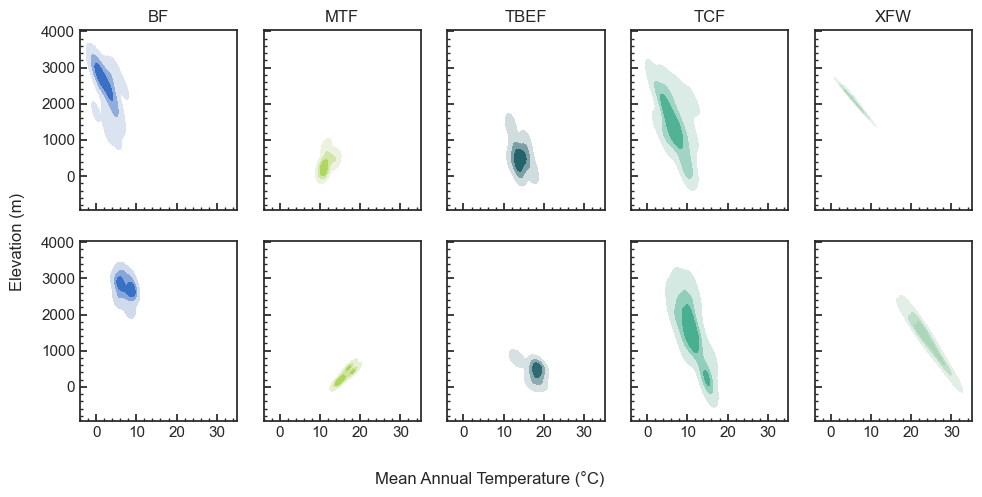

In [11]:

# Define color maps
cmap1 = mcolors.LinearSegmentedColormap.from_list("cmap1", [(0, "#F7F7F7"), (1, "#0F52BA")])
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", [(0, "#F7F7F7"), (1, "#9ACD32")])
cmap3 = mcolors.LinearSegmentedColormap.from_list("cmap3", [(0, "#F7F7F7"), (1, "#004953")])
cmap4 = mcolors.LinearSegmentedColormap.from_list("cmap4", [(0, "#F7F7F7"), (1, "#1B9D77")])
cmap5 = mcolors.LinearSegmentedColormap.from_list("cmap5", [(0, "#F7F7F7"), (1, "#A4D4B4")])

# Create dictionary of colormaps
cmap_dict = {
    "cmap1": ([0, 1], [(0.97, 0.97, 0.97), (0.46, 0.44, 0.70)]),
    "cmap2": ([0, 1], [(0.97, 0.97, 0.97), (0.60, 0.80, 0.20)]),
    "cmap3": ([0, 1], [(0.97, 0.97, 0.97), (0.00, 0.29, 0.33)]),
    "cmap4": ([0, 1], [(0.97, 0.97, 0.97), (0.11, 0.62, 0.47)]),
    "cmap5": ([0, 1], [(0.97, 0.97, 0.97), (0.64, 0.83, 0.71)])
}

# Define the required POTVEGs and their colors
potvegs = {
    "BF": cmap1,
    "MTF": cmap2,
    "TBEF": cmap3,
    "TCF": cmap4,
    "XFW": cmap5,
}

# Create a figure with 2 rows and 5 columns
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),  sharey=True, sharex=True)
sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})
# Loop through the POTVEGs and create a KDE subplot for each one
for i, (potveg, color) in enumerate(potvegs.items()):
    
    # Plot the historical_all_variable data in the top row
    sns.kdeplot(
        data=historical_all_variables[historical_all_variables["POTVEG"] == potveg],
        x="AVE_TAIR",
        y="ELEVATION",
        thresh=0.05,
        cmap=color,
        levels=4,
        alpha=1,
        shade=True,
        
        ax=axs[0, i],
    )
    axs[0, i].set_title("")
    
    # Plot the future_all_variable data in the bottom row
    sns.kdeplot(
        data=future_all_variables[future_all_variables["POTVEG"] == potveg],
        x="AVE_TAIR",
        y="ELEVATION",
        thresh=0.05,
        cmap=color,
        levels=4,
        alpha=1,
        shade=True,
       
        ax=axs[1, i],
    )
    axs[1, i].set_title("")
    
       # Remove individual x and y axis labels
    axs[0, i].set_xlabel("")
    axs[0, i].set_ylabel("")
    axs[1, i].set_xlabel("")
    axs[1, i].set_ylabel("")
    
    # Add a common x and y axis label for the whole figure
    fig.supxlabel("Mean Annual Temperature (°C)", fontsize=12)
    fig.supylabel("Elevation (m)", fontsize=12)
    
    # Set the POTVEG name as the column title
    axs[0, i].set_title(potveg)
    

# set the spacing between subplots
# set x ticks
plt.xticks(np.arange(0, 35, step=10))
plt.subplots_adjust( hspace=0.2)


plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.right"] = False
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["figure.autolayout"] = True

plt.savefig("../figures/range_elve_temp_space.svg",format="svg",dpi=1200,bbox_inches="tight",)



  
plt.show()




In [7]:
"""
# Group by POTVEG and calculate mean for each variable except LAT and LON

historical_all_variables = (historical_all_variables.groupby("POTVEG").mean().reset_index())
future_all_variables = future_all_variables.groupby("POTVEG").mean().reset_index()



# Evelevation vs. Mean Annual Temperature
# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.set_theme(style="ticks", font="sans-serif", rc={"lines.linewidth": 2.5})

# Plot historical data on the left axis
sns.scatterplot(
    x="AVE_TAIR",
    y="ELEVATION",
    hue="POTVEG",
    data=historical_all_variables,
    ax=ax1,
    legend=False,
    palette=palette,
    edgecolor="black",
    s=200,
    linewidth=0.2,
)


# Draw horizontal lines for each POTVEG mean elevation
potveg_values = historical_all_variables["POTVEG"].unique()
for potveg in potveg_values:
    elevation_value = historical_all_variables[
        historical_all_variables["POTVEG"] == potveg
    ]["ELEVATION"].iloc[0]
    ax1.axhline(y=elevation_value, color=palette[potveg], linestyle="--", linewidth=2)

# Set axis labels and title
ax1.set_title("a) Observed Historical (1984-2014)")
ax1.set_xlabel("")
ax1.set_ylabel("")

# Plot end of century data on the right axis
sns.scatterplot(
    x="AVE_TAIR",
    y="ELEVATION",
    hue="POTVEG",
    data=future_all_variables,
    ax=ax2,
    palette=palette,
    edgecolor="black",
    s=200,
    linewidth=0.2,
)

# Draw horizontal lines for each POTVEG mean elevation
potveg_values = future_all_variables["POTVEG"].unique()
for potveg in potveg_values:
    elevation_value = future_all_variables[future_all_variables["POTVEG"] == potveg][
        "ELEVATION"
    ].iloc[0]
    ax2.axhline(y=elevation_value, color=palette[potveg], linestyle="--", linewidth=2)

# Set axis labels and title

ax2.set_title("b) Modeled End of Century (2070 - 2100)")
ax2.set_xlabel("")

# Create color lines for each category in the color palette
arid_line = mlines.Line2D(
    [],
    [],
    color=palette["Arid Shrublands"],
    marker="o",
    markersize=8,
    label="Arid Shrublands",
)
boreal_line = mlines.Line2D(
    [],
    [],
    color=palette["Boreal Forests"],
    marker="o",
    markersize=8,
    label="Boreal Forests",
)
mixed_line = mlines.Line2D(
    [],
    [],
    color=palette["Mixed Temperate Forests"],
    marker="o",
    markersize=8,
    label="Mixed Temperate Forests",
)
short_line = mlines.Line2D(
    [],
    [],
    color=palette["Short Grasslands"],
    marker="o",
    markersize=8,
    label="Short Grasslands",
)
broad_line = mlines.Line2D(
    [],
    [],
    color=palette["Temperate Broadleaved Evergreen Forests"],
    marker="o",
    markersize=8,
    label="Temperate Broadleaved Evergreen Forests",
)
conif_line = mlines.Line2D(
    [],
    [],
    color=palette["Temperate Coniferous Forests"],
    marker="o",
    markersize=8,
    label="Temperate Coniferous Forests",
)
decid_line = mlines.Line2D(
    [],
    [],
    color=palette["Temperate Deciduous Forests"],
    marker="o",
    markersize=8,
    label="Temperate Deciduous Forests",
)
xero_line = mlines.Line2D(
    [],
    [],
    color=palette["Xeromorphic Forests and Woodlands"],
    marker="o",
    markersize=8,
    label="Xeromorphic Forests and Woodlands",
)

# Set figure legend
handles = [
    arid_line,
    boreal_line,
    mixed_line,
    short_line,
    broad_line,
    conif_line,
    decid_line,
    xero_line,
]
labels = [line.get_label() for line in handles]
fig.legend(
    handles=handles,
    labels=labels,
    loc="center",
    bbox_to_anchor=(0.5, -0.07),
    ncol=2,
    frameon=False,
)

# Remove the legend from the second subplot
ax2.legend_.remove()

fig.supylabel("Mean Elevation (m)", fontsize=12, y=0.50)
fig.supxlabel("Mean Annual Temperature (°C)", fontsize=12, y=0.05)
plt.ylim(0, 3000)

# Show the plot
plt.subplots_adjust(wspace=0.5)
plt.tight_layout(pad=0.5)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.top"] = False
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["xtick.major.size"] = 10
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.right"] = False
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["figure.autolayout"] = True

# adjust the margins
fig.subplots_adjust(bottom=0.15)


plt.savefig(
    "../figures/elve_temp_space.svg",
    format="svg",
    dpi=1200,
    bbox_inches="tight",
    pad_inches=0.1,
)

plt.show()
"""
print("1")

1


In [8]:
#Correlation Analysis:

pft_labels = {
    "BF": "Boreal Forests",
    "MTF": "Mixed Temperate Forests",
    "TCF": "Temperate Coniferous Forests",
    "TDF": "Temperate Deciduous Forests",
    "SG": "Short Grasslands",
    "AS": "Arid Shrublands",
    "XFW": "Xeromorphic Forests and Woodlands",
    "TBEF": "Temperate Broadleaved Evergreen Forests",
}




# Subset the columns of interest
historical_subset = historical_all_variables[['ELEVATION','AVE_TAIR', 'TOTAL_PREC', 'BETA','TOTAL_NPP', 'POTVEG']]
historical_subset ["POTVEG"] = historical_subset ["POTVEG"].map(pft_labels)
future_subset = future_all_variables[['AVE_TAIR', 'TOTAL_PREC', 'BETA','TOTAL_NPP', 'POTVEG']]
future_subset ["POTVEG"] = future_subset ["POTVEG"].map(pft_labels)
future_subset=future_subset.rename(columns={'BETA':'AET/PET'})

# Calculate the correlation coefficients
#historical_corr = historical_subset.corr(method='pearson')
future_corr = future_subset.corr(method='pearson')

# Or, calculate Spearman rank correlation coefficients
# historical_corr = historical_subset.corr(method='spearman')
#future_corr = future_subset.corr(method='spearman')

# Plot the correlation matrices using seaborn heatmap
#sns.heatmap(historical_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.figure(figsize=(6, 6), dpi=1200)
sns.heatmap(future_corr, cmap='viridis', annot=True, vmin=-1, vmax=1, annot_kws={"size": 10}, yticklabels=True)
plt.title(" b)")
#remove cbar
plt.gca().collections[0].colorbar.remove()

plt.rcParams["font.size"] = 10
plt.savefig(
    "../figures/corr.svg",
    format="svg",
    dpi=1200,
    bbox_inches="tight",
    pad_inches=0.1,
)

The positive and negative values in the correlation matrix represent the direction of the correlation between two variables. A positive value indicates a positive correlation, meaning that when one variable increases, the other variable tends to increase as well. A negative value indicates a negative correlation, meaning that when one variable increases, the other variable tends to decrease. The closer the correlation coefficient is to 1 or -1, the stronger the correlation between the variables. A correlation coefficient of 0 indicates no correlation between the variables.

Principal component 1: 0.571
Principal component 2: 0.318
Principal component 3: 0.111
1. BETA
2. AVE_TAIR
3. TOTAL_PREC


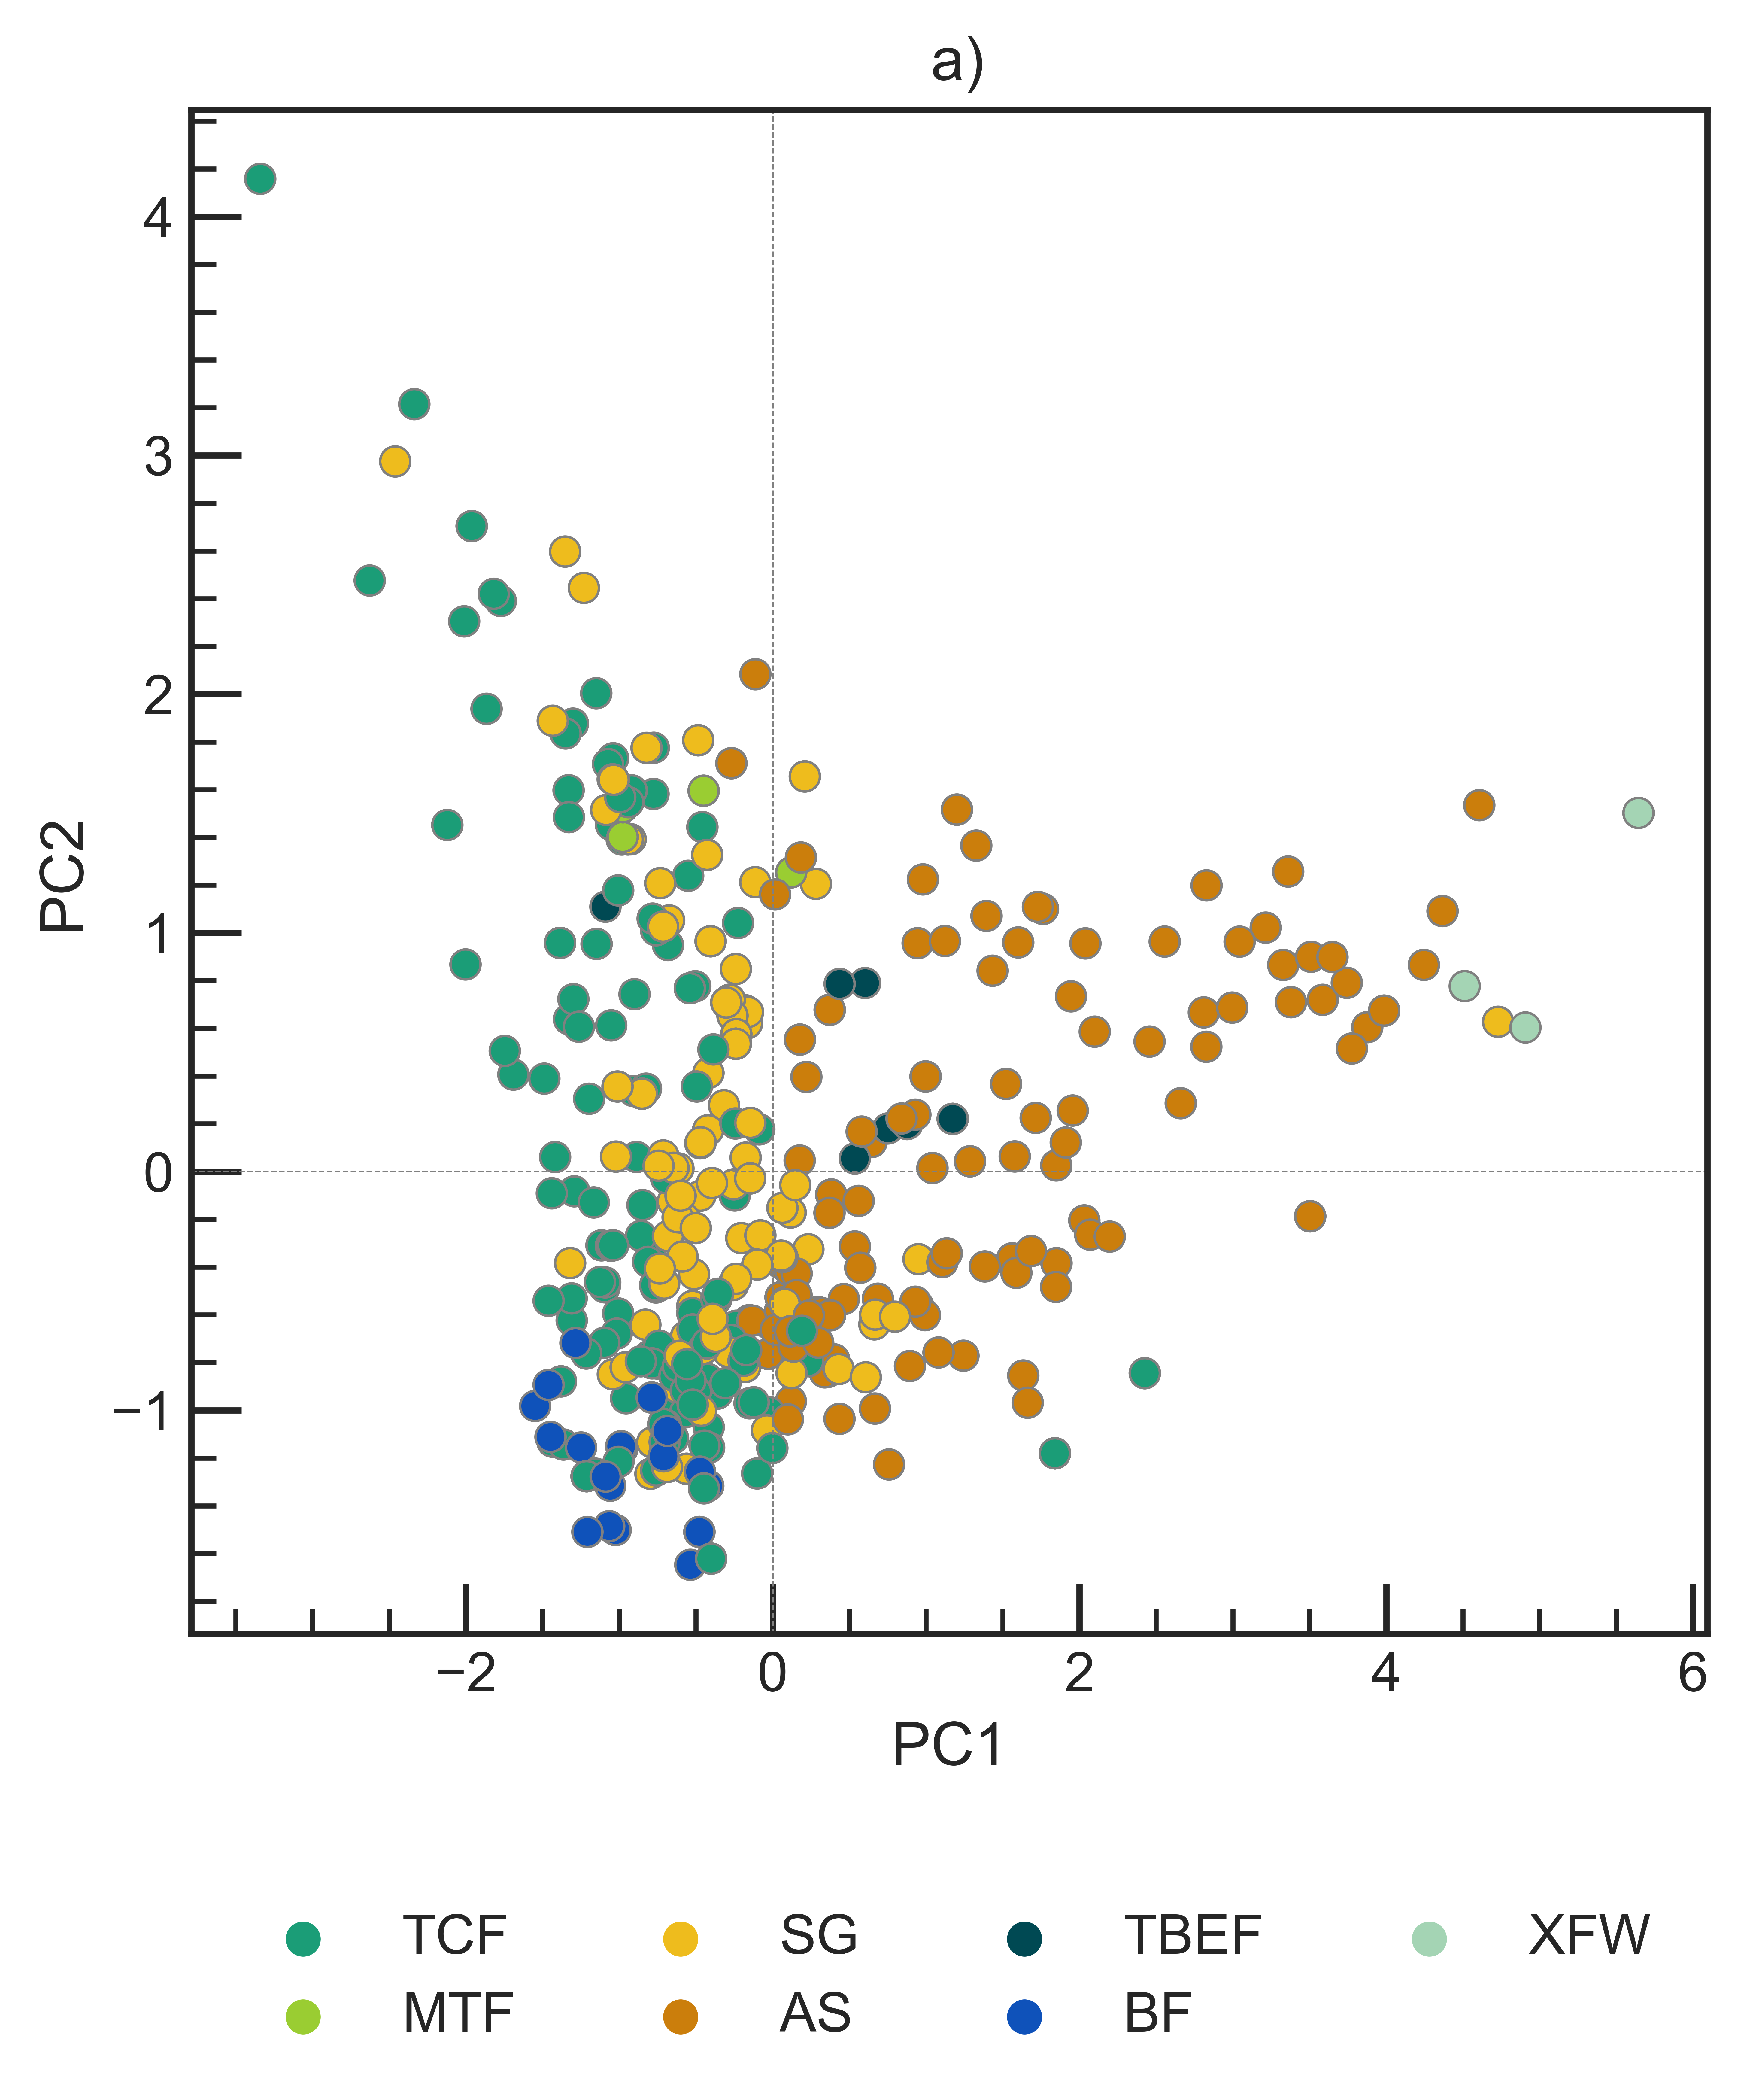

In [12]:
# Concatenate the two data frames


future_pca=future_all_variables[['ELEVATION','AVE_TAIR', 'TOTAL_PREC', 'BETA','TOTAL_NPP', 'POTVEG']]
future_df = future_pca
future_df=future_df .dropna()
combined_df_potveg=future_df
# Extract the climatic variables from the combined data frame
climatic_variables = future_df[['AVE_TAIR', 'TOTAL_PREC', 'BETA']]

# Standardize the climatic variables
climatic_variables_standardized = (climatic_variables - climatic_variables.mean()) / climatic_variables.std()


# Perform PCA on the standardized climatic variables
pca = PCA()
pca.fit(climatic_variables_standardized)

# Get the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Print the explained variance ratio of each principal component
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Principal component {i+1}: {ratio:.3f}")
# Get the coefficients of the variables in the first principal component
coefficients = pd.DataFrame(pca.components_, columns=climatic_variables.columns)

# Get the absolute values of the coefficients
absolute_coefficients = coefficients.abs()

# Print the ranking of the variables by importance
ranked_variables = absolute_coefficients.iloc[0].sort_values(ascending=False).index
for i, variable in enumerate(ranked_variables):
    print(f"{i+1}. {variable}")


# Get the first two principal components
pca_df = pd.DataFrame(pca.transform(climatic_variables_standardized)[:, :2], columns=['PC1', 'PC2'])

# Add the vegetation type to the data frame
pca_df['POTVEG'] = combined_df_potveg['POTVEG'].values

# Color Palette
palette = {
    "AS": "#cb7e0c",
    "BF": "#0F52BA",
    "MTF": "#9ACD32",
    "SG": "#EEBC1D",
    "TBEF": "#004953",
    "TCF": "#1b9d77",
    "TDF": "#7570b3",
    "XFW": "#A4D4B4",
    "Total": "grey",
}

# Create the scatter plot
plt.figure(figsize=(5, 6), dpi=1200)
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='POTVEG', palette=palette,edgecolor='gray',)
# Plot Horizontal Line at y=0 and Vertical Line at x=0
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.3)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.3)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4,frameon=False)
plt.minorticks_on()
plt.tick_params(
    direction="in",
    which="minor",
    length=5,
    bottom=True,
    top=False,
    left=True,
    right=False,
)
plt.tick_params(
    direction="in",
    which="major",
    length=10,
    bottom=True,
    top=False,
    left=True,
    right=False,
)

plt.title(" a)")
plt.savefig(
    "../figures/pca.svg",
    format="svg",
    dpi=1200,
    bbox_inches="tight",
    pad_inches=0.1,
)




The last plot shows a scatter plot of the first two principal components of the standardized climatic variables. The x-axis represents the first principal component (PC1), and the y-axis represents the second principal component (PC2).

Each point on the scatter plot represents a grid in the historical and future data frames, and the color of the point represents the vegetation type at that grid. The plot shows how the vegetation types in the historical and future data frames are distributed in the PC1-PC2 space.

The values of PC1 and PC2 are the scores of each grid on the first and second principal components, respectively. These scores are calculated by multiplying the standardized climatic variables of each grid by the coefficients of the first and second principal components and summing the products. The resulting scores are the coordinates of the grid in the PC1-PC2 space.

The scatter plot can be used to identify patterns and clusters in the distribution of the vegetation types in the PC1-PC2 space. For example, if there is a clear separation between two groups of vegetation types, this suggests that there are distinct climatic factors that determine the distribution of these vegetation types. On the other hand, if the vegetation types are distributed randomly in the PC1-PC2 space, this suggests that there is no clear relationship between the climatic factors and the distribution of these vegetation types